In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import random
import math
import cv2


In [47]:
from collections import namedtuple
Circle = namedtuple('Circle', ['x', 'y', 'r', 'O', 'c'])
Rectangle = namedtuple('Rectangle', ['x', 'y', 'k', 'a', 'b', 'O', 'c'])
# x & y : any float (location of center of the obstacle)
# r: radius of circle
# k: angle of the rectangle (0 to pi/2)
# a, b: sides of the rectangle
# O, c: opacity and color of the obstacle

# color_map, polar_map -> uint8 array
# opacity_map -> bool array

class actor:
    def __init__(self, map_size, initial_location = None):
        self.map_size = map_size
        self.opacity_map = np.full((map_size, map_size), False)
        self.color_map = np.zeros([map_size, map_size], dtype = np.uint8);
        self.initial_location = initial_location if (initial_location != None) else (int(map_size/2),int(map_size/2))
        self.Y,self.X = np.meshgrid(np.linspace(1, self.map_size ,self.map_size),np.linspace(1, self.map_size ,self.map_size))
        self.x = int(map_size/2)
        self.y = int(map_size/2)
        self.polar_angle_size = 256
        self.polar_dist_size = 256
        self.n_circles = 20
        self.n_rectangles = 20
        self.polar_map = np.zeros([self.polar_dist_size, self.polar_angle_size], dtype = np.uint8)
        self.view = np.zeros([self.polar_angle_size])
        self.depth = np.zeros([self.polar_angle_size])
    def initialize_terrain(self):
        A = [Circle(x = random.randrange(0, self.map_size), 
                    y = random.randrange(0, self.map_size), 
                    r = random.randrange(0, int(self.map_size/2)), 
                    O = bool(random.getrandbits(1)), 
                    c = random.randrange(1, 255)) for i in range(self.n_circles)]
        A += [Rectangle(x = random.randrange(0, self.map_size), 
                        y = random.randrange(0, self.map_size), 
                        k = random.uniform(0, math.pi/2), 
                        a = random.uniform(0, self.map_size), 
                        b = random.uniform(0, self.map_size), 
                        O = bool(random.getrandbits(1)), 
                        c = random.randrange(1, 255)) for j in range(self.n_rectangles)]
        self.generate_terrain(A)
    def generate_terrain(self, A):
        for i in A:
            if type(i).__name__ == 'Circle':
                mask = self.circular_obstacle(i)
            elif type(i).__name__ == 'Rectangle':
                mask = self.rectangular_obstacle(i)
            if not (mask & (self.circular_obstacle(Circle(x = self.x, y = self.y, r = 16, O = True, c = 255)).astype(bool))).any():
                if i.O:
                    self.opacity_map = np.logical_or(mask, self.opacity_map)
                    self.color_map = self.color_map*(~mask)+(i.c*mask).astype(np.uint8)
                else:
                    self.opacity_map = np.logical_and(~mask, self.opacity_map)
                    self.color_map = self.color_map*(~mask)
    def generate_view(self):
        self.padded_map = cv2.copyMakeBorder(self.color_map, self.map_size*2, self.map_size*2, self.map_size*2, self.map_size*2, cv2.BORDER_CONSTANT, 0)
        self.polar_map = cv2.warpPolar(self.padded_map, self.polar_map.shape, (self.map_size*2+self.y,self.map_size*2+self.x), 256, flags = cv2.INTER_NEAREST+cv2.WARP_POLAR_LINEAR)
        self.polar_map = np.flip(np.roll(self.polar_map, -int(self.map_size/4), axis = 0), axis = 0)
        mask = self.polar_map!=0
        self.depth = np.where(mask.any(axis=1), mask.argmax(axis=1), 0)
        self.view = self.polar_map[np.arange(self.polar_angle_size), self.depth]
    def circular_obstacle(self, i):
        return (self.X-i.x)**2 + (self.Y-i.y)**2 <= i.r**2
    def rectangular_obstacle(self, i):
        return  np.logical_and((np.abs((self.X-i.x)/(np.cos(i.k)+0.001)-(self.Y-i.y)/(np.sin(i.k)+0.001)))<=(i.a*np.abs(np.tan(i.k)+1/(np.tan(i.k)+0.001))/2),
                               (np.abs((self.X-i.x)/(np.sin(i.k)+0.001)+(self.Y-i.y)/(np.cos(i.k)+0.001)))<=(i.b*np.abs(np.tan(i.k)+1/(np.tan(i.k)+0.001))/2))



In [48]:
a = actor(256)
A = [Rectangle(x = 50, y = 40, k = 0.5, a = 40, b = 40, O = True, c = 80),
     Rectangle(x = 80, y = 20, k = 0.0, a = 40, b = 40, O = False, c = 28),
     Rectangle(x = 180, y = 90, k = 0.8, a = 100, b = 10, O = True, c = 50),
     Circle(x = 130, y = 230, r = 80, O = True, c = 30),
     Circle(x = 100, y = 90, r = 40, O = True, c = 200),
     Circle(x = 30, y = 130, r = 20, O = True, c = 50),]
a.initialize_terrain()
#a.generate_terrain(A)
plt.subplot(1,4,1)
plt.imshow(a.color_map.T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,4,2)
plt.imshow(a.opacity_map.T, cmap='gray')
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,4,3)

a.generate_view()
plt.imshow(a.polar_map)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,4,4)
plt.plot(a.depth)
plt.show()

<IPython.core.display.Javascript object>


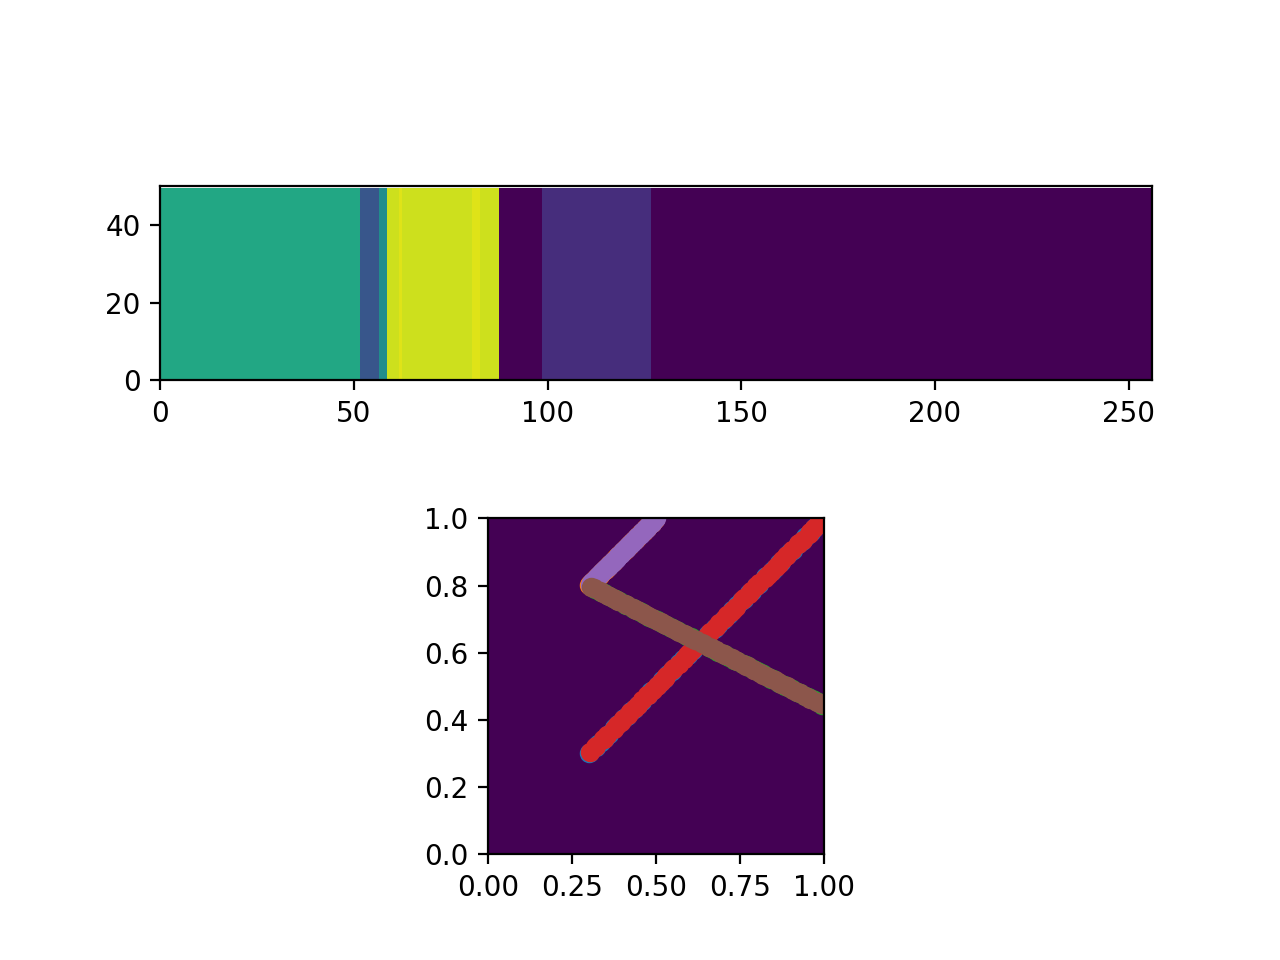

[154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154
 154  68  68  68  68  68  68  68  68  68  68  68  68  68  68  68  68  68
  68  68  68 125 125  68  68  68  68 125 125 125 125 125 125 125 125 236
 236 236 236 236 243 243 243 243 236 236 236 236 236 236 236 236 236 236
 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236
 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236
 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236
 236 236 236 236 236 236 236 236 236 236 236   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  33  33  33  33  33  33  33  33  33  33  33
  33  33  33  33  33  33  33  33  33  33  33  33  33  33  33  33  33  33
  33  33  33  33  33  33  33   0   0   0   0   0   0   0   0   0   0   0
   0   0 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154
 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154 154
 154 154 154 154 154 154 154 154 154 154 154 154 15

In [49]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig = plt.figure()
plt.subplot(2,1,1)
im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
plt.xlim(0,256)
plt.ylim(0,50)
print(a.view)
plt.subplot(2,1,2)
im2 = plt.imshow(a.color_map.T, vmin=0, vmax=256)
plt.xlim(0,256)
plt.ylim(0,256)
pos = plt.scatter([a.x],[a.y],color='r')
plt.xlim(0,256)
plt.ylim(0,256)
              
def init():
    plt.subplot(2,1,1)
    im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
    plt.subplot(2,1,2)
    pos = plt.scatter([a.x],[a.y],color='r')
    return [im1]

def animate(frame_num):
    if a.y < a.map_size and a.y >= 0:
        a.y-=1
    a.generate_view()
    plt.subplot(2,1,1)
    im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
    plt.subplot(2,1,2)
    pos = plt.scatter([a.x],[a.y],color='r')
    return [im1, pos]
                
anim = FuncAnimation(fig, animate, frames=100, interval=1)
plt.show()

In [52]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as f

In [53]:
class Nerf_Model(nn.Module):
    def __init__(self, map_size, view_size):
        super().__init__()
        self.occupancy = nn.Sequential(nn.Linear(32, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 65),
                                       nn.ReLU(inplace=True))
        self.color = nn.Sequential(nn.Linear(64,32),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(32, 1),
                                   nn.Sigmoid())
        self.map_size = map_size
        self.view_size = view_size
    
    def forward(self, p):
        X = self.positional_encoder(p)
        X = self.occupancy(X)
        o = X[:,:1]
        c = self.color(X[:,1:])
        return torch.cat([o, c], dim = 1)
        
        
    def positional_encoder(self, P):
        P = P.reshape((-1, 2, 1)).tile(1,1,8)
        w = 2 ** torch.linspace(0, 7, steps=8).tile(P.shape[0],2,1)
        P *= math.pi * w
        P = torch.cat([torch.cos(P), torch.sin(P)], dim = 2)
        return P.reshape(P.shape[0],-1)
        
M = Nerf_Model(256, 256);
print(M(torch.tensor([[0.28, 0.382], [0.01,0.01],[0, 0],[0, 0],[0.01,0.01]])))

tensor([[0.1485, 0.4976],
        [0.1255, 0.4977],
        [0.1386, 0.4979],
        [0.1386, 0.4979],
        [0.1255, 0.4977]], grad_fn=<CatBackward>)


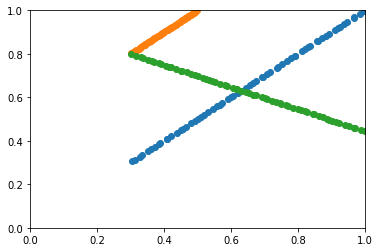

In [65]:
N = 64

#ray point sampling


def end_point(p, a):
    r = 2 * math.pi * (a)
    smooth = 10**-6
    x = p[:,0]
    y = p[:,1]
    T = torch.stack([-x/(torch.cos(r)+smooth), 
                     -y/(torch.sin(r)+smooth), 
                     (1-x)/(torch.cos(r)+smooth), 
                     (1-y)/(torch.sin(r)+smooth)])
    T = torch.min(torch.where(T>=0, T, 10*torch.ones(T.shape)), 0)[0]
    return torch.stack([x + T * torch.cos(r), y + T * torch.sin(r)]).T

def rand_samp(p):
    p, a = p[:,:2], p[:,2]
    p_e = end_point(p, a)
    p_e = p_e[:,:2]
    p_i = torch.linspace(0, N-1, N)
    p_i = p_i.reshape((1, N, 1)) * (p_e-p).reshape((p.shape[0], 1, 2)) / N
    randn = torch.rand(p.shape[0],N)
    p_i = p_i + randn.reshape((p.shape[0],N,1)) * (p_e-p).reshape((p.shape[0], 1, 2)) / N
    return p_i + p.reshape(p.shape[0],1,2)

p = rand_samp(torch.tensor([[0.3,0.3,0.125], [0.3,0.8,0.125],[0.3,0.8,0.925], [0.3,0.8,0.925]]))
plt.scatter(p[0,:,0],p[0,:,1])
plt.scatter(p[1,:,0],p[1,:,1])
plt.scatter(p[2,:,0],p[2,:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [66]:
# p: [[c,x,y,r],...[c,x,y,r]]
criterion = nn.MSELoss()
def photo_loss(model, p):
    rand_points = rand_samp(p[:,1:])
    output = model(torch.squeeze(rand_points,dim = 1)).reshape((-1, N, 2))
    dists = (torch.roll(rand_points, -1, 1) - torch.roll(rand_points, 1, 1))/2
    dists[:,0,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
    dists[:,-1,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
    dist = (dists[:,:,0]**2 + dists[:,:,1]**2)**0.5
    sigma = torch.tril(torch.ones((N,N)),diagonal=-1)
    T = torch.exp(-torch.matmul(sigma, (output[:,:,0]*dist).T).T)
    #print(T)
    C = T * (1 - torch.exp(-output[:,:,0] * dist)) * output[:,:,1]
    #print(output[:,:,1])
    C = torch.sum(C, dim = 1)
    loss = criterion(C, p[:,0])
    #print(C)
    return loss
photo_loss(M,torch.tensor([[0.1,0.3,0.3,0.125],[0.1,0.3,0.8,0.125],[0.1,0.3,0.8,0.125]]))

tensor(0.0044, grad_fn=<MseLossBackward>)

In [67]:
a = torch.tensor([[0.,0.,0.,0.],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]])
photo_loss(M, a)

tensor(0.1442, grad_fn=<MseLossBackward>)

In [68]:
def gen_viewpoints(actor, n_sample):
    samplecount = 0
    viewpoints = torch.tensor([])
    while samplecount < n_sample:
        actor.x, actor.y = random.randint(0, actor.map_size-1), random.randint(0, actor.map_size-1)
        if actor.opacity_map[a.x,a.y] == False:
            samplecount += 1
            actor.generate_view()
            view = torch.cat([torch.from_numpy(actor.view.reshape((-1,1)))/256, 
                                torch.tensor([a.x]).expand(256,1)/256, 
                                torch.tensor([a.y]).expand(256,1)/256, 
                                torch.linspace(0,1,256).reshape(256,1)], dim = 1)
            viewpoints = torch.cat([viewpoints, view], dim = 0)
    return viewpoints

def train(model, n, n_batch, p, optim):
    optim.zero_grad()
    #print(torch.index_select(p, 0, torch.randint(0, p.shape[0], (n_batch,))))
    loss = photo_loss(model, torch.index_select(p, 0, torch.randint(0, p.shape[0], (n_batch,))))
    loss.backward()
    optim.step()
    return loss.item()


In [69]:
import wandb

wandb.init(project="Robovision", entity="gyungmin")

wandb: Currently logged in as: gyungmin (use `wandb login --relogin` to force relogin)


In [ ]:
learning_rate = 1*10**-5
n_epoch = 100000
model = Nerf_Model(256, 256)
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

a = actor(256);
a.initialize_terrain()


model.train()
for i in range(n_epoch):
    p = gen_viewpoints(a, 128)
    loss = train(model, 1, 512, p, optim)
    print(loss)
    wandb.log({"loss": loss})



0.1526930332183838
0.1904217153787613
0.1768893301486969
0.17401182651519775
0.14938102662563324
0.17363770306110382
0.1971501260995865
0.18193678557872772
0.18176230788230896
0.20670847594738007
0.20927971601486206
0.16129925847053528
0.14573581516742706
0.17547821998596191
0.1946428418159485
0.2005297839641571
0.16079014539718628
0.18169523775577545
0.18655438721179962
0.18109926581382751
0.1837719976902008
0.16415488719940186
0.1766272485256195
0.14529916644096375
0.15642940998077393
0.1788027137517929
0.20569446682929993
0.16435551643371582
0.1675742119550705
0.23695823550224304
0.16915830969810486
0.19297027587890625
0.1632554531097412
0.22881954908370972
0.19675283133983612
0.18746651709079742
0.17958050966262817
0.18752846121788025
0.18285730481147766
0.17744849622249603
0.19670332968235016
0.17815624177455902
0.19026724994182587
0.1706314980983734
0.15186846256256104
0.1682640016078949
0.17526215314865112
0.15891329944133759
0.1892063021659851
0.16989096999168396
0.165479823946

0.15560677647590637
0.16844619810581207
0.14935460686683655
0.15305571258068085
0.13425154983997345
0.16724395751953125
0.18405157327651978
0.16033899784088135
0.19555939733982086
0.18966823816299438
0.1593766212463379
0.15855853259563446
0.13464872539043427
0.14804162085056305
0.1563238948583603
0.14756709337234497
0.1658111810684204
0.1524798572063446
0.15747876465320587
0.15661221742630005
0.13523276150226593
0.14898595213890076
0.15667138993740082
0.16055314242839813
0.16656963527202606
0.20837073028087616
0.1350792944431305
0.15689334273338318
0.16540591418743134
0.1520645171403885
0.17852871119976044
0.1553327590227127
0.16755768656730652
0.15902075171470642
0.16099241375923157
0.19707037508487701
0.15787848830223083
0.15683841705322266
0.1410444974899292
0.1802707314491272
0.1412321776151657
0.18527626991271973
0.15400689840316772
0.16875651478767395
0.1615777164697647
0.1610560119152069
0.15730778872966766
0.1733943372964859
0.14640748500823975
0.17572835087776184
0.12025193870

0.11305684596300125
0.11646407097578049
0.1195523738861084
0.10429424792528152
0.1003398597240448
0.1601407527923584
0.12588106095790863
0.1425073742866516
0.13248789310455322
0.1522618979215622
0.10194869339466095
0.11697492748498917
0.11692323535680771
0.10079585015773773
0.11942526698112488
0.120003342628479
0.13034752011299133
0.13593974709510803
0.11087609827518463
0.10959942638874054
0.13671045005321503
0.12407161295413971
0.13390375673770905
0.12591241300106049
0.11792872846126556
0.11164843291044235
0.11271651834249496
0.10725808888673782
0.10999323427677155
0.10980142652988434
0.1305810660123825
0.10258790850639343
0.1284557729959488
0.1279624104499817
0.1078353002667427
0.11827953904867172
0.12686234712600708
0.11467120051383972
0.13992908596992493
0.12214896082878113
0.14009708166122437
0.1245323121547699
0.12950484454631805
0.1107906699180603
0.1261482685804367
0.12265492975711823
0.12237004935741425
0.11494599282741547
0.1343487799167633
0.12014000862836838
0.1388073563575

0.08840391784906387
0.074494868516922
0.06868141144514084
0.07108066976070404
0.07133970409631729
0.0745486244559288
0.09517066180706024
0.08875498175621033
0.09999215602874756
0.10117565095424652
0.06795064359903336
0.08092823624610901
0.07888485491275787
0.06688441336154938
0.095955029129982
0.09601078927516937
0.08199357241392136
0.09110120683908463
0.09361644089221954
0.07049353420734406
0.1001567617058754
0.08166417479515076
0.07161837816238403
0.07138415426015854
0.08218900114297867
0.10009072721004486
0.08211013674736023
0.08426973223686218
0.10127578675746918
0.09187855571508408
0.0721902921795845
0.08878711611032486
0.06714687496423721
0.09154430031776428
0.0783366858959198
0.0941338762640953
0.07751571387052536
0.08632028847932816
0.09649816155433655
0.07981173694133759
0.07687122374773026
0.0789966732263565
0.07657735794782639
0.08144434541463852
0.08878136426210403
0.08377791196107864
0.09231685847043991
0.07114534825086594
0.08072708547115326
0.08057508617639542
0.07994410

0.07308439910411835
0.07329174876213074
0.07821843773126602
0.08265417814254761
0.07030853629112244
0.07679450511932373
0.07450522482395172
0.08189161866903305
0.07172755151987076
0.0733218714594841
0.07519491016864777
0.06585335731506348
0.08022265136241913
0.08987964689731598
0.07477569580078125
0.06565408408641815
0.0760752260684967
0.06685788929462433
0.07239159941673279
0.0778818428516388
0.07030925154685974
0.07461956143379211
0.07298079878091812
0.08794578909873962
0.08336798846721649
0.0695025846362114
0.06825391203165054
0.0813697949051857
0.06472849100828171
0.07071052491664886
0.07764202356338501
0.06994443386793137
0.06870266795158386
0.06850474327802658
0.0841190367937088
0.06873545050621033
0.08009469509124756
0.06860113143920898
0.0723697692155838
0.07386098802089691
0.06319505721330643
0.061713799834251404
0.07477124780416489
0.059135351330041885
0.07376411557197571
0.06864892691373825
0.07127469778060913
0.08183974772691727
0.08937742561101913
0.06646525114774704
0.073

0.07086668908596039
0.06291712075471878
0.06297045201063156
0.05982504040002823
0.061717357486486435
0.06829871982336044
0.06624785810709
0.06567343324422836
0.07229410856962204
0.06708530336618423
0.07092589139938354
0.06399416923522949
0.06673133373260498
0.06418095529079437
0.06679356098175049
0.05648839473724365
0.07782810926437378
0.07290338724851608
0.07325097918510437
0.0705128163099289
0.07634850591421127
0.05660412833094597
0.07030220329761505
0.07116501778364182
0.07714734226465225
0.06129849702119827
0.06039826199412346
0.0679745152592659
0.06538096815347672
0.06335338950157166
0.08326906710863113
0.09251341223716736
0.0660724863409996
0.06236600875854492
0.07769965380430222
0.07167838513851166
0.0635426789522171
0.06712587177753448
0.07298502326011658
0.051702044904232025
0.06304462999105453
0.07269790023565292
0.0747307762503624
0.0788235068321228
0.0694195106625557
0.07070012390613556
0.07580537348985672
0.05710230767726898
0.05979697406291962
0.05977035313844681
0.062969

0.057179152965545654
0.06874164193868637
0.06449019908905029
0.07290482521057129
0.051677871495485306
0.0680394247174263
0.07239989936351776
0.055494725704193115
0.06446295231580734
0.06594966351985931
0.05834195762872696
0.08207080513238907
0.05647257715463638
0.053070563822984695
0.06845129281282425
0.07715579867362976
0.06332965940237045
0.07180467993021011
0.053545840084552765
0.06765123456716537
0.06035389006137848
0.05601876229047775
0.07069309800863266
0.0630379319190979
0.06374015659093857
0.08740514516830444
0.053253259509801865
0.05827277898788452
0.06605486571788788
0.06480931490659714
0.06145940348505974
0.055200934410095215
0.05828341096639633
0.07159058004617691
0.07070380449295044
0.061787474900484085
0.052701763808727264
0.07036536186933517
0.07099997997283936
0.06923908740282059
0.06617819517850876
0.05479935184121132
0.05414877086877823
0.059199009090662
0.0636972114443779
0.05648159980773926
0.06854143738746643
0.0677163153886795
0.05338244140148163
0.065407454967498

0.0687229260802269
0.05965132266283035
0.05926179885864258
0.06469904631376266
0.06133267283439636
0.0651908814907074
0.0675751119852066
0.055644914507865906
0.058673277497291565
0.06162850558757782
0.056042395532131195
0.051876239478588104
0.05807400494813919
0.05524064600467682
0.061456456780433655
0.05840616673231125
0.058404505252838135
0.07245174795389175
0.06172268092632294
0.0617826022207737
0.061774399131536484
0.06498504430055618
0.059904325753450394
0.04857950285077095
0.06748250871896744
0.056977808475494385
0.06592915952205658
0.06728104501962662
0.05809757113456726
0.060390911996364594
0.05807485803961754
0.06893458962440491
0.06092487648129463
0.053777046501636505
0.04587339609861374
0.06903281807899475
0.050167266279459
0.06070986017584801
0.06211436539888382
0.06621667742729187
0.05596699193120003
0.06062820553779602
0.06465116143226624
0.06695806980133057
0.05937665328383446
0.05711284279823303
0.06730642169713974
0.05623232200741768
0.06189711391925812
0.0531327314674

0.04575179144740105
0.049459945410490036
0.051432643085718155
0.06352737545967102
0.05934737250208855
0.049194417893886566
0.06050264835357666
0.05280856788158417
0.05612829327583313
0.05004667490720749
0.05318266525864601
0.056880734860897064
0.05292682349681854
0.054160602390766144
0.060413908213377
0.05646498128771782
0.04950771853327751
0.06260670721530914
0.05092426389455795
0.052302286028862
0.06204763427376747
0.055002499371767044
0.04611712694168091
0.058336734771728516
0.048973262310028076
0.04809874668717384
0.05643462762236595
0.04711426421999931
0.06021028012037277
0.0521836057305336
0.0560823529958725
0.058673057705163956
0.05000462010502815
0.06265582144260406
0.05055269971489906
0.05899948254227638
0.03937552869319916
0.05537600815296173
0.051057469099760056
0.06258898973464966
0.04906400293111801
0.045345015823841095
0.05486755445599556
0.058836646378040314
0.04491773620247841
0.05687359720468521
0.04633656144142151
0.05304335802793503
0.049000803381204605
0.05404671281

0.047955892980098724
0.05972679331898689
0.049999915063381195
0.05001380294561386
0.04746326059103012
0.053341444581747055
0.05184845253825188
0.05142928659915924
0.05171512812376022
0.0429886132478714
0.05444485321640968
0.061921458691358566
0.04667738452553749
0.04252687096595764
0.04967368766665459
0.04833298176527023
0.0548831932246685
0.046162862330675125
0.04941884055733681
0.055877890437841415
0.05212806165218353
0.048978421837091446
0.04692547023296356
0.039202071726322174
0.035914771258831024
0.04677467793226242
0.0505320243537426
0.04757538437843323
0.05365914851427078
0.04234485700726509
0.04831656441092491
0.05171846225857735
0.05177690088748932
0.051221542060375214
0.048462867736816406
0.05303066968917847
0.053020257502794266
0.0505877360701561
0.05345580726861954
0.0516386553645134
0.059073980897665024
0.0418231263756752
0.044090986251831055
0.05231036618351936
0.0460008941590786
0.04195321351289749
0.04371403902769089
0.061776209622621536
0.051150523126125336
0.049760356

0.04228552058339119
0.054419469088315964
0.04186202958226204
0.040485236793756485
0.04530835896730423
0.043087705969810486
0.06071045249700546
0.05578872188925743
0.0437016598880291
0.047337330877780914
0.04233003035187721
0.042874567210674286
0.04950915649533272
0.050309084355831146
0.04604622721672058
0.0497811883687973
0.04950908571481705
0.04290322959423065
0.04885429888963699
0.051015596836805344
0.051359597593545914
0.052426137030124664
0.046213407069444656
0.05058890953660011
0.05096879228949547
0.04985610023140907
0.041340213268995285
0.04753813147544861
0.0417834147810936
0.040243618190288544
0.04196342080831528
0.03990425541996956
0.03948596864938736
0.04977937415242195
0.04760457202792168
0.046424638479948044
0.04220150411128998
0.045324064791202545
0.04367384687066078
0.04547766596078873
0.053252965211868286
0.05331898480653763
0.05120592564344406
0.045088592916727066
0.05725573003292084
0.05244649201631546
0.04043973609805107
0.04969875514507294
0.03961200639605522
0.04839

0.04727788269519806
0.0447256863117218
0.048467639833688736
0.05057631805539131
0.04034479334950447
0.04748984053730965
0.04400648921728134
0.044316958636045456
0.04591761901974678
0.03907555341720581
0.03954605013132095
0.042426690459251404
0.04163997247815132
0.04709126055240631
0.03779509291052818
0.045398179441690445
0.04869292676448822
0.05776876211166382
0.05362397059798241
0.054047711193561554
0.04428030923008919
0.047420259565114975
0.05416968837380409
0.046087391674518585
0.051935721188783646
0.04606741666793823
0.03764163702726364
0.04687702655792236
0.059442758560180664
0.03885790705680847
0.048947058618068695
0.05283500999212265
0.033595629036426544
0.048238497227430344
0.04624209925532341
0.04854036495089531
0.044315505772829056
0.053228963166475296
0.04768100008368492
0.051883384585380554
0.0382293201982975
0.04990299791097641
0.049709923565387726
0.041369277983903885
0.05376182496547699
0.0516573004424572
0.047291748225688934
0.04384597763419151
0.04733673483133316
0.049

0.044547878205776215
0.046807412058115005
0.043645404279232025
0.055250417441129684
0.04518783465027809
0.04647098481655121
0.04329456016421318
0.044116996228694916
0.045838866382837296
0.043304283171892166
0.0391266830265522
0.04881956800818443
0.04323691874742508
0.045051321387290955
0.04234591871500015
0.04206852614879608
0.04412158578634262
0.04568207636475563
0.04956480860710144
0.04491604119539261
0.04242699593305588
0.043677762150764465
0.04634566605091095
0.03882645070552826
0.041051603853702545
0.060029689222574234
0.04106079787015915
0.04873879253864288
0.041737623512744904
0.043217845261096954
0.04846135526895523
0.03890405595302582
0.04197534918785095
0.0533326081931591
0.03723851963877678
0.04625745862722397
0.03320101276040077
0.049082156270742416
0.05492272600531578
0.03849202021956444
0.04437907785177231
0.04443962126970291
0.0423089899122715
0.04536003619432449
0.05105765908956528
0.044293954968452454
0.03644874319434166
0.04996485263109207
0.05015392228960991
0.043226

0.036001525819301605
0.039036981761455536
0.04186543822288513
0.047598350793123245
0.040370360016822815
0.04602062329649925
0.046890098601579666
0.045816726982593536
0.04437614232301712
0.03885738179087639
0.05004686862230301
0.046096205711364746
0.040061067789793015
0.051562387496232986
0.044004544615745544
0.03580218926072121
0.04569712653756142
0.036906927824020386
0.03806622698903084
0.04634559899568558
0.036054596304893494
0.045280199497938156
0.04068409278988838
0.0569600984454155
0.04535982012748718
0.05068307742476463
0.055128566920757294
0.04044850915670395
0.05618712678551674
0.04800001531839371
0.042738813906908035
0.04156309738755226
0.0460345633327961
0.042996492236852646
0.047865577042102814
0.04236217960715294
0.03831271082162857
0.04432264715433121
0.045836400240659714
0.04627321660518646
0.031173281371593475
0.046311475336551666
0.04319765418767929
0.05548334866762161
0.047439076006412506
0.0451773963868618
0.05053200572729111
0.03662921488285065
0.05000075697898865
0.

0.03744823858141899
0.041078634560108185
0.04415849596261978
0.04062637314200401
0.040253862738609314
0.044009797275066376
0.04596173018217087
0.048048149794340134
0.04540335759520531
0.03424730896949768
0.04232011362910271
0.04060376435518265
0.04592392221093178
0.037671107798814774
0.03268859535455704
0.04038179665803909
0.038429342210292816
0.037829361855983734
0.03870570287108421
0.039242252707481384
0.037377603352069855
0.041473694145679474
0.04322598874568939
0.03793169558048248
0.04088551923632622
0.04142092168331146
0.044400013983249664
0.03390410169959068
0.040131717920303345
0.04875960573554039
0.03469925746321678
0.0441446378827095
0.04543377831578255
0.03992617502808571
0.03648640215396881
0.03838145360350609
0.0402224101126194
0.051272280514240265
0.05344271659851074
0.041229210793972015
0.040311943739652634
0.03895778954029083
0.038246218115091324
0.048602256923913956
0.04072599112987518
0.03784077987074852
0.045485250651836395
0.0461777001619339
0.03712230548262596
0.042

0.038191262632608414
0.037542760372161865
0.04113757610321045
0.03947192803025246
0.03666126728057861
0.03722653165459633
0.042871326208114624
0.037052515894174576
0.03655492886900902
0.05144578963518143
0.03879721090197563
0.04198703542351723
0.04169579967856407
0.04231100529432297
0.03516469523310661
0.04061565920710564
0.04162156581878662
0.04565616697072983
0.04713863506913185
0.03045465424656868
0.03556543588638306
0.04493254795670509
0.04122483357787132
0.03729705885052681
0.04146208241581917
0.039376355707645416
0.04812619462609291
0.042568087577819824
0.039502259343862534
0.043775834143161774
0.0481671541929245
0.044848859310150146
0.035366885364055634
0.03982500731945038
0.038877226412296295
0.05432555824518204
0.04434504359960556
0.049494124948978424
0.037459831684827805
0.03687203675508499
0.04951777309179306
0.04407446086406708
0.043340131640434265
0.03621025010943413
0.037172526121139526
0.050483375787734985
0.0453108511865139
0.04332263767719269
0.04121213033795357
0.0414

0.04374841973185539
0.03730388730764389
0.04317516088485718
0.03890302777290344
0.03862461820244789
0.037417229264974594
0.03685618191957474
0.04529927670955658
0.039809390902519226
0.03875723481178284
0.038867563009262085
0.04220857843756676
0.04818641021847725
0.04247137904167175
0.03987432271242142
0.041085124015808105
0.038875728845596313
0.0521891750395298
0.03739207237958908
0.0351380929350853
0.040552131831645966
0.03836211934685707
0.034039098769426346
0.04247066378593445
0.04054085165262222
0.03589530289173126
0.03524266555905342
0.04075039550662041
0.035128168761730194
0.04157378152012825
0.038162633776664734
0.04197908192873001
0.03830847144126892
0.053653184324502945
0.046843670308589935
0.03861497342586517
0.039300788193941116
0.04315844550728798
0.03734137862920761
0.037264540791511536
0.044731155037879944
0.046273402869701385
0.038269154727458954
0.03458857163786888
0.04137745499610901
0.044489167630672455
0.04113425314426422
0.041772857308387756
0.04068155214190483
0.03

0.035583075135946274
0.035414919257164
0.0334649458527565
0.036941420286893845
0.041004426777362823
0.03594162315130234
0.04726231098175049
0.03952841833233833
0.034072086215019226
0.03874971717596054
0.04799728840589523
0.05177280306816101
0.04379125311970711
0.0493692122399807
0.036020539700984955
0.035255856812000275
0.0400468073785305
0.036057088524103165
0.04595480114221573
0.04202723503112793
0.05744472146034241
0.04042572155594826
0.03946007788181305
0.04095277190208435
0.03191671893000603
0.03527830168604851
0.04378867521882057
0.03138625994324684
0.03760509192943573
0.041369494050741196
0.03683444857597351
0.03605106845498085
0.03338785842061043
0.03799457848072052
0.03522555157542229
0.04424210265278816
0.03882329910993576
0.04252425208687782
0.034168366342782974
0.03445446863770485
0.03876149281859398
0.0427200011909008
0.044657811522483826
0.04080963879823685
0.04003661125898361
0.04001618176698685
0.04603193327784538
0.03290470689535141
0.034097328782081604
0.0329204760491

0.03607432171702385
0.03359232842922211
0.03098919801414013
0.03526809811592102
0.035861510783433914
0.039221324026584625
0.035943448543548584
0.03161705657839775
0.040626946836709976
0.03382110968232155
0.03449975326657295
0.04129353165626526
0.043536826968193054
0.035566963255405426
0.03522958979010582
0.03490547090768814
0.035758357495069504
0.035191185772418976
0.033178217709064484
0.03004160150885582
0.033710695803165436
0.04695655405521393
0.032062217593193054
0.0315852016210556
0.03992404416203499
0.03438040241599083
0.040934763848781586
0.04051953926682472
0.028500765562057495
0.034932319074869156
0.03299293294548988
0.036689650267362595
0.032870832830667496
0.035443294793367386
0.03672915697097778
0.03897225111722946
0.036959730088710785
0.039047252386808395
0.03909377008676529
0.03295263275504112
0.0337243378162384
0.036935362964868546
0.03867987543344498
0.04163016006350517
0.04012688249349594
0.04197271913290024
0.03653991222381592
0.032688964158296585
0.03243853524327278
0

0.03384740278124809
0.03850846737623215
0.03970237821340561
0.036265574395656586
0.03531825169920921
0.0333683043718338
0.03315179422497749
0.04120442271232605
0.029817957431077957
0.04388098418712616
0.032776594161987305
0.03178052976727486
0.0385657474398613
0.04344351962208748
0.04145132377743721
0.03521069884300232
0.040803782641887665
0.03802110254764557
0.040615011006593704
0.03812425956130028
0.03536979481577873
0.03363548219203949
0.033153850585222244
0.03763066977262497
0.041164983063936234
0.03820345178246498
0.02767900750041008
0.034441255033016205
0.04241158813238144
0.03699960187077522
0.03973032534122467
0.03624286502599716
0.027953971177339554
0.0414477176964283
0.03153246268630028
0.033061861991882324
0.0364447720348835
0.03162210434675217
0.03708670288324356
0.0343753956258297
0.03853016346693039
0.03485232591629028
0.03994645178318024
0.03778890147805214
0.031895723193883896
0.030635762959718704
0.04592510685324669
0.03638594597578049
0.03414156660437584
0.03914828225

0.03626325726509094
0.035655565559864044
0.035815659910440445
0.03340284526348114
0.032232023775577545
0.03339793533086777
0.03868171572685242
0.03231112286448479
0.03558303043246269
0.0321059413254261
0.032914672046899796
0.04295174404978752
0.045405879616737366
0.03410477936267853
0.044413868337869644
0.03268169239163399
0.03328804671764374
0.04053160175681114
0.037288181483745575
0.03930285573005676
0.030627727508544922
0.04109456017613411
0.031248789280653
0.03343275934457779
0.034983981400728226
0.03345635160803795
0.03271785005927086
0.031309060752391815
0.040308233350515366
0.03357686102390289
0.03532993793487549
0.029265569522976875
0.043763674795627594
0.03245209529995918
0.03198913484811783
0.03176913782954216
0.04403368756175041
0.05196177214384079
0.028043556958436966
0.03138314560055733
0.033421799540519714
0.03694741055369377
0.038135431706905365
0.037631839513778687
0.03419459983706474
0.03738328814506531
0.031711380928754807
0.035499654710292816
0.03726350516080856
0.03

In [ ]:
model.eval()
pred = torch.zeros((256,256,2))
for i in range(256):
    for j in range(256):
        #print(model(torch.tensor([[i/256,j/256]])).shape)
        pred[i,j] = model(torch.tensor([[i/256,j/256]]))[0]

plt.subplot(1,3,1)
plt.imshow(a.color_map.T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,3,2)
plt.imshow(pred.detach().numpy()[:,:,0].T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,3,3)
plt.imshow(pred.detach().numpy()[:,:,1].T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,3,4)
plt.show()

In [ ]:
actor.x, actor.y = 128, 128
actor.generate_view()
view = torch.cat([torch.from_numpy(actor.view.reshape((-1,1)))/256, 
                  torch.tensor([a.x]).expand(256,1)/256, 
                  torch.tensor([a.y]).expand(256,1)/256, 
                  torch.linspace(0,1,256).reshape(256,1)], dim = 1)
viewpoints = torch.cat([viewpoints, view], dim = 0)
rand_points = rand_samp(viewpoints[:,1:])
output = model(torch.squeeze(rand_points,dim = 1)).reshape((-1, N, 2))
dists = (torch.roll(rand_points, -1, 1) - torch.roll(rand_points, 1, 1))/2
dists[:,0,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
dists[:,-1,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
dist = (dists[:,:,0]**2 + dists[:,:,1]**2)**0.5
sigma = torch.tril(torch.ones((N,N)),diagonal=-1)
T = torch.exp(-torch.matmul(sigma, (output[:,:,0]*dist).T).T)
C = T * (1 - torch.exp(-output[:,:,0] * dist)) * output[:,:,1]
C = torch.sum(C, dim = 1)